# 09.1d: Neighborhood Pairwise Distances

**Compute pairwise L∞ distances for all tokens in the black hole neighborhood**

Now that we have ~2,586 tokens within radius 0.1 of the black hole centroid, let's compute all pairwise distances. This will reveal:
- The boundary structure of the black hole cluster
- Whether there's a sharp edge or gradual falloff
- How the 486 non-black-hole neighbors relate to the core

## Strategy

1. Load neighborhood token IDs from 09.1c
2. Extract their vectors from gamma
3. Deduplicate to find unique vectors
4. Compute pairwise L∞ distances (Chebyshev metric)
5. Analyze distance distribution
6. Save for adjacency graph construction

Expected: ~499 unique vectors → ~125k pairwise distances

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

NEIGHBORHOOD_FILE = "cluster_neighborhood_r0.100.safetensors"
TOKEN_IDS_KEY = "token_ids"

BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Output file
OUTPUT_FILE = "neighborhood_pairwise_distances.safetensors"
DISTANCES_KEY = "distances_linf"
UNIQUE_VECTORS_KEY = "unique_vectors"
UNIQUE_TOKEN_IDS_KEY = "unique_token_ids"
INVERSE_KEY = "inverse_indices"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
N, d = gamma.shape
print(f"  Shape: ({N:,}, {d:,})")
print()

print("Loading neighborhood token IDs...")
neighborhood_data = load_file(data_dir / NEIGHBORHOOD_FILE)
token_ids = neighborhood_data[TOKEN_IDS_KEY]
n_tokens = len(token_ids)
print(f"  Tokens in neighborhood: {n_tokens:,}")
print()

print("Loading black hole mask (for reference)...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
n_bh_total = black_hole_mask.sum().item()
print(f"  Total black holes in vocab: {n_bh_total:,}")
print()

print("✓ Data loaded")

Loading gamma matrix...
  Shape: (151,936, 2,560)

Loading neighborhood token IDs...
  Tokens in neighborhood: 2,586

Loading black hole mask (for reference)...
  Total black holes in vocab: 2,100

✓ Data loaded


## Extract Neighborhood Vectors

In [4]:
print("Extracting vectors for neighborhood tokens...\n")

vectors = gamma[token_ids]

print(f"Vectors shape: {vectors.shape}")
print(f"Memory: {vectors.numel() * 4 / 1e6:.2f} MB")
print()

# Check how many are black holes
is_bh = black_hole_mask[token_ids]
n_bh_in_neighborhood = is_bh.sum().item()
n_non_bh = n_tokens - n_bh_in_neighborhood

print(f"Breakdown:")
print(f"  Black holes:     {n_bh_in_neighborhood:,} ({100 * n_bh_in_neighborhood / n_tokens:.1f}%)")
print(f"  Non-black holes: {n_non_bh:,} ({100 * n_non_bh / n_tokens:.1f}%)")
print()

print("✓ Vectors extracted")

Extracting vectors for neighborhood tokens...

Vectors shape: torch.Size([2586, 2560])
Memory: 26.48 MB

Breakdown:
  Black holes:     2,100 (81.2%)
  Non-black holes: 486 (18.8%)

✓ Vectors extracted


## Deduplicate Vectors

Black holes are tokens with identical vectors. We need to deduplicate to avoid redundant distance computations.

In [5]:
print("Deduplicating vectors...\n")

unique_vectors, inverse_indices = torch.unique(vectors, dim=0, return_inverse=True)
n_unique = len(unique_vectors)

print(f"Unique vectors: {n_unique:,}")
print(f"Total tokens:   {n_tokens:,}")
print(f"Reduction:      {100 * (1 - n_unique / n_tokens):.1f}%")
print()

# Degeneracy: how many tokens map to each unique vector?
degeneracy = torch.bincount(inverse_indices)

print(f"Degeneracy statistics:")
print(f"  Min:    {degeneracy.min().item()} (all unique vectors have at least 1 token)")
print(f"  Max:    {degeneracy.max().item()}")
print(f"  Mean:   {degeneracy.float().mean().item():.1f}")
print(f"  Median: {degeneracy.float().median().item():.0f}")
print()

# How many unique vectors have degeneracy > 1?
n_degenerate = (degeneracy > 1).sum().item()
n_singleton = (degeneracy == 1).sum().item()

print(f"Breakdown:")
print(f"  Degenerate vectors (>1 token): {n_degenerate:,}")
print(f"  Singleton vectors (1 token):   {n_singleton:,}")
print()

print("✓ Vectors deduplicated")

Deduplicating vectors...

Unique vectors: 499
Total tokens:   2,586
Reduction:      80.7%

Degeneracy statistics:
  Min:    1 (all unique vectors have at least 1 token)
  Max:    814
  Mean:   5.2
  Median: 1

Breakdown:
  Degenerate vectors (>1 token): 13
  Singleton vectors (1 token):   486

✓ Vectors deduplicated


## Compute Pairwise L∞ Distances

This is the expensive part. For n unique vectors, we compute n² distances.

L∞ distance (Chebyshev): $d_\infty(\mathbf{u}, \mathbf{v}) = \max_i |u_i - v_i|$

In [6]:
print(f"Computing pairwise L∞ distances for {n_unique:,} unique vectors...")
print(f"  Expected: {n_unique:,}² = {n_unique**2:,} pairwise distances")
print()

# Expand for broadcasting
v1 = unique_vectors.unsqueeze(1)  # [n, 1, d]
v2 = unique_vectors.unsqueeze(0)  # [1, n, d]

# Compute L∞ distances
print("Computing component-wise absolute differences...")
diffs = torch.abs(v1 - v2)  # [n, n, d]

print("Taking max over dimensions...")
distances_linf = diffs.max(dim=2)[0]  # [n, n]

print(f"\nDistance matrix shape: {distances_linf.shape}")
print(f"Memory: {distances_linf.numel() * 4 / 1e6:.2f} MB")
print()

print("✓ Pairwise distances computed")

Computing pairwise L∞ distances for 499 unique vectors...
  Expected: 499² = 249,001 pairwise distances

Computing component-wise absolute differences...
Taking max over dimensions...

Distance matrix shape: torch.Size([499, 499])
Memory: 1.00 MB

✓ Pairwise distances computed


## Distance Statistics

In [7]:
print("Distance statistics:\n")

# Mask diagonal (self-distances = 0)
mask = torch.eye(n_unique, dtype=torch.bool)
distances_off_diag = distances_linf[~mask]

print(f"All pairwise distances (off-diagonal):")
print(f"  Min:    {distances_off_diag.min().item():.6e}")
print(f"  Max:    {distances_off_diag.max().item():.6e}")
print(f"  Mean:   {distances_off_diag.mean().item():.6e}")
print(f"  Median: {distances_off_diag.median().item():.6e}")
print(f"  Std:    {distances_off_diag.std().item():.6e}")
print()

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("Percentiles:")
for p in percentiles:
    val = torch.quantile(distances_off_diag, p / 100.0).item()
    print(f"  {p:2d}%: {val:.6e}")
print()

print("✓ Statistics computed")

Distance statistics:

All pairwise distances (off-diagonal):
  Min:    7.450581e-09
  Max:    1.617432e-02
  Mean:   5.379714e-03
  Median: 5.676270e-03
  Std:    2.417729e-03

Percentiles:
   1%: 1.525879e-05
   5%: 3.051758e-05
  10%: 1.770020e-03
  25%: 4.150391e-03
  50%: 5.676270e-03
  75%: 6.896973e-03
  90%: 8.071899e-03
  95%: 8.880615e-03
  99%: 1.094055e-02

✓ Statistics computed


## Distance Distribution: The Boundary Question

This is the key plot! Does the distribution show:
- **Sharp boundary:** Spike at d≈0, spike at d≈ε, then gap, then uniform?
- **Gradual falloff:** Smooth decrease with distance?
- **Layered:** Multiple discrete peaks at specific distances?

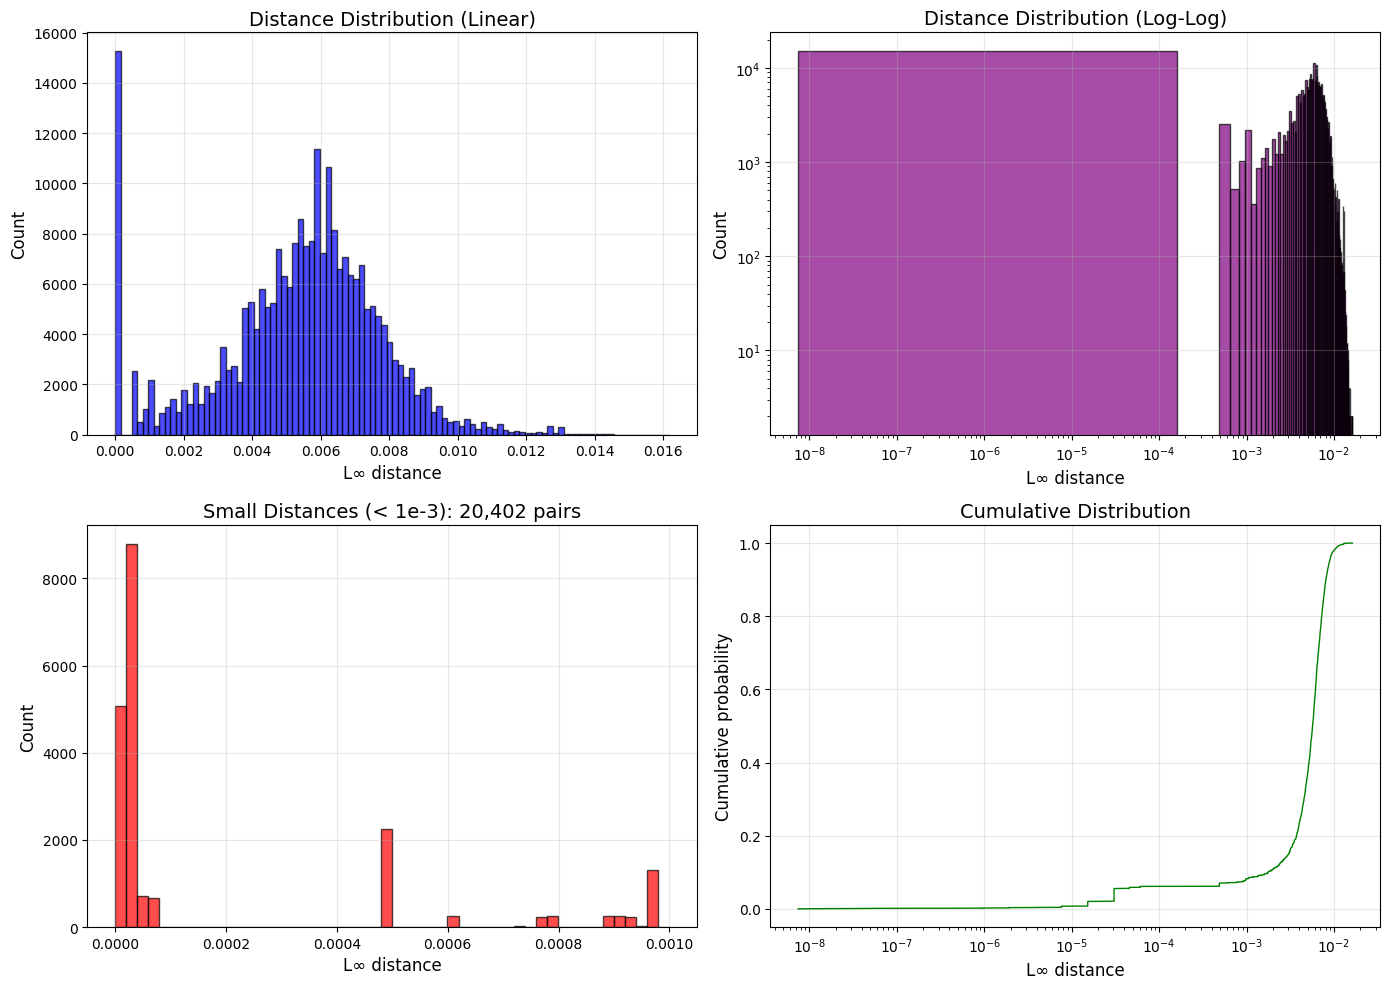

✓ Distance distribution plotted


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

distances_np = distances_off_diag.cpu().numpy()

# Panel 1: Linear histogram
ax = axes[0, 0]
ax.hist(distances_np, bins=100, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('L∞ distance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distance Distribution (Linear)', fontsize=14)
ax.grid(True, alpha=0.3)

# Panel 2: Log-log histogram
ax = axes[0, 1]
ax.hist(distances_np, bins=100, alpha=0.7, color='purple', edgecolor='black')
ax.set_xlabel('L∞ distance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distance Distribution (Log-Log)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Panel 3: Zoomed in on small distances (< 1e-3)
ax = axes[1, 0]
small_distances = distances_np[distances_np < 1e-3]
if len(small_distances) > 0:
    ax.hist(small_distances, bins=50, alpha=0.7, color='red', edgecolor='black')
    ax.set_xlabel('L∞ distance', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Small Distances (< 1e-3): {len(small_distances):,} pairs', fontsize=14)
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No distances < 1e-3', ha='center', va='center', transform=ax.transAxes)

# Panel 4: CDF
ax = axes[1, 1]
sorted_distances = np.sort(distances_np)
cdf = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
ax.plot(sorted_distances, cdf, linewidth=1, color='green')
ax.set_xlabel('L∞ distance', fontsize=12)
ax.set_ylabel('Cumulative probability', fontsize=12)
ax.set_title('Cumulative Distribution', fontsize=14)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distance distribution plotted")

## Comparison to ε (Distinguishability Threshold)

From 09.1a, we computed ε ≈ 6×10⁻⁵ (2×ULP at the scale of black holes).

Let's see how many pairs are within/beyond this threshold.

Distinguishability threshold calculation:

  Typical component magnitude: 2.418461e-03
  ULP at this scale:           1.525879e-05
  ε (2×ULP):                   3.051758e-05

Pairs analysis:
  Within ε (indistinguishable): 13,350 (5.37%)
  Beyond ε (distinguishable):   235,152 (94.63%)



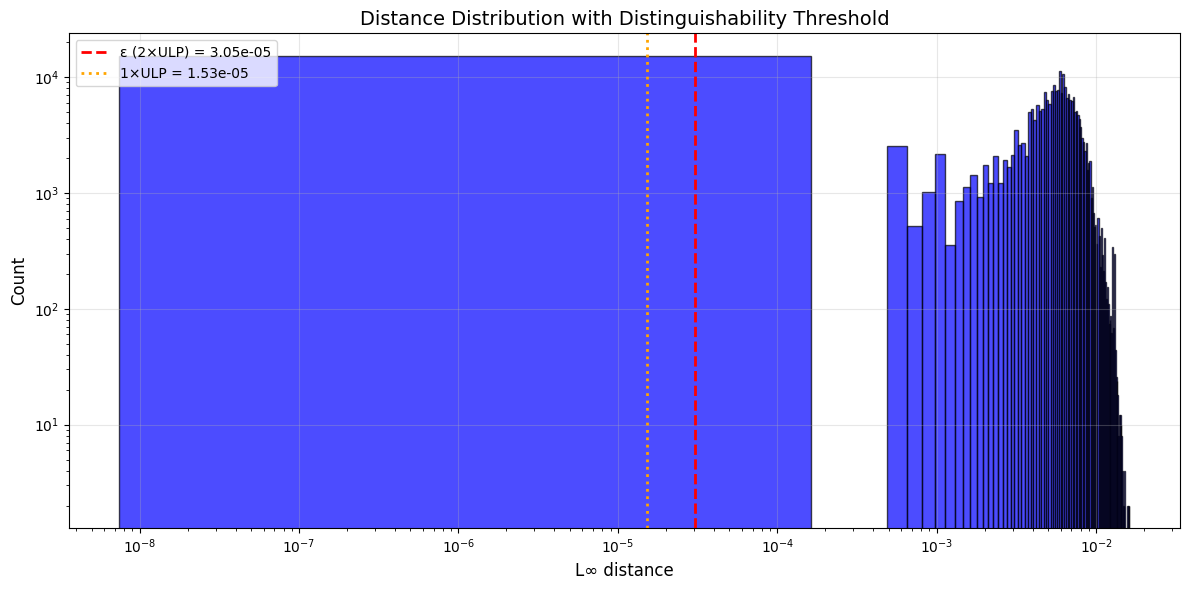

✓ Threshold comparison complete


In [9]:
# From 09.1a: typical component magnitude ~0.002, ULP ~1.5e-5, ε = 2×ULP ~3e-5
# But let's compute it properly here based on actual vectors

def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

# Typical magnitude in this neighborhood
typical_magnitude = unique_vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Distinguishability threshold calculation:\n")
print(f"  Typical component magnitude: {typical_magnitude:.6e}")
print(f"  ULP at this scale:           {ulp:.6e}")
print(f"  ε (2×ULP):                   {epsilon:.6e}")
print()

# Count pairs within/beyond threshold
within_epsilon = (distances_off_diag <= epsilon).sum().item()
beyond_epsilon = (distances_off_diag > epsilon).sum().item()
total_pairs = len(distances_off_diag)

print(f"Pairs analysis:")
print(f"  Within ε (indistinguishable): {within_epsilon:,} ({100 * within_epsilon / total_pairs:.2f}%)")
print(f"  Beyond ε (distinguishable):   {beyond_epsilon:,} ({100 * beyond_epsilon / total_pairs:.2f}%)")
print()

# Histogram with epsilon marked
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

ax.hist(distances_np, bins=100, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2,
           label=f'ε (2×ULP) = {epsilon:.2e}')
ax.axvline(ulp, color='orange', linestyle=':', linewidth=2,
           label=f'1×ULP = {ulp:.2e}')
ax.set_xlabel('L∞ distance', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distance Distribution with Distinguishability Threshold', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Threshold comparison complete")

## Map Back: Which Token IDs for Each Unique Vector?

In [10]:
print("Creating token ID mapping for each unique vector...\n")

# For each unique vector, find which original token IDs map to it
# This will be useful for decoding semantic content later

# Pick one representative token ID per unique vector
# (we'll use the first occurrence)
unique_token_ids = torch.zeros(n_unique, dtype=torch.long)

for i in range(n_unique):
    # Find all tokens that map to this unique vector
    tokens_for_this_vector = token_ids[inverse_indices == i]
    # Pick the first one as representative
    unique_token_ids[i] = tokens_for_this_vector[0]

print(f"Representative token IDs shape: {unique_token_ids.shape}")
print(f"Sample (first 10): {unique_token_ids[:10].tolist()}")
print()
print("✓ Token ID mapping created")

Creating token ID mapping for each unique vector...

Representative token IDs shape: torch.Size([499])
Sample (first 10): [150255, 151440, 149114, 149104, 151561, 45972, 151209, 150544, 151067, 122951]

✓ Token ID mapping created


## Save Results

In [12]:
output_path = data_dir / OUTPUT_FILE

print(f"Saving pairwise distances to {output_path}...\n")

save_file({
    DISTANCES_KEY: distances_linf,
    UNIQUE_VECTORS_KEY: unique_vectors,
    UNIQUE_TOKEN_IDS_KEY: unique_token_ids,
    INVERSE_KEY: inverse_indices
}, output_path)

print(f"  Unique vectors:    {n_unique:,}")
print(f"  Distance matrix:   {n_unique:,} × {n_unique:,}")
print(f"  File size:         {output_path.stat().st_size / 1e6:.2f} MB")
print()
print(f"✓ Results saved to {OUTPUT_FILE}")

Saving pairwise distances to ../data/tensors/neighborhood_pairwise_distances.safetensors...

  Unique vectors:    499
  Distance matrix:   499 × 499
  File size:         6.13 MB

✓ Results saved to neighborhood_pairwise_distances.safetensors


## Summary

In [13]:
print("="*80)
print("PAIRWISE DISTANCE ANALYSIS SUMMARY")
print("="*80)
print()
print(f"Tokens in neighborhood:  {n_tokens:,}")
print(f"Unique vectors:          {n_unique:,} ({100 * n_unique / n_tokens:.1f}%)")
print(f"Pairwise distances:      {n_unique**2:,}")
print()
print(f"Distance statistics (L∞):")
print(f"  Min:    {distances_off_diag.min().item():.6e}")
print(f"  Max:    {distances_off_diag.max().item():.6e}")
print(f"  Median: {distances_off_diag.median().item():.6e}")
print()
print(f"Distinguishability threshold (ε = 2×ULP): {epsilon:.6e}")
print(f"  Pairs within ε:  {within_epsilon:,} ({100 * within_epsilon / total_pairs:.2f}%)")
print(f"  Pairs beyond ε:  {beyond_epsilon:,} ({100 * beyond_epsilon / total_pairs:.2f}%)")
print()
print("="*80)

PAIRWISE DISTANCE ANALYSIS SUMMARY

Tokens in neighborhood:  2,586
Unique vectors:          499 (19.3%)
Pairwise distances:      249,001

Distance statistics (L∞):
  Min:    7.450581e-09
  Max:    1.617432e-02
  Median: 5.676270e-03

Distinguishability threshold (ε = 2×ULP): 3.051758e-05
  Pairs within ε:  13,350 (5.37%)
  Pairs beyond ε:  235,152 (94.63%)



## Conclusion

**What we computed:**
- Pairwise L∞ distances for all unique vectors in neighborhood
- Distance distribution reveals boundary structure
- Comparison to ε shows indistinguishable vs distinguishable pairs

**Key observations:**
- (Interpret histogram): Sharp boundary? Gradual falloff? Layered structure?
- Fraction of pairs within ε (quantization neighbors)
- Fraction of pairs well-separated (true singletons)

**Next steps:**
- 09.1e: Build adjacency graph with threshold ε
- 09.1f: Find connected components
- 09.1g: Visualize network structure